In [26]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import requests
from matplotlib.backends.backend_pdf import PdfPages

## read in the daily values for the entire history of Lee's Ferry and the Grand Canyon

In [27]:
site_num = {'Lees Ferry':'09380000',"Grand Canyon": '09402500'}
urls = dict()
for ckey,cval in site_num.items():
    dv_url = 'http://waterservices.usgs.gov/nwis/dv/?format=rdb'
    dv_url += '&sites={0}'.format(cval)
    #dv_url += '&startDT=2010-01-01'
    dv_url += '&startDT=1880-01-01'
    #dv_url += '&endDT=2018-01-17'
    dv_url += '&parameterCd=00060'
    print(dv_url)
    urls[ckey] = dv_url

http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=09380000&startDT=1880-01-01&parameterCd=00060
http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=09402500&startDT=1880-01-01&parameterCd=00060


In [28]:
urls

{'Grand Canyon': 'http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=09402500&startDT=1880-01-01&parameterCd=00060',
 'Lees Ferry': 'http://waterservices.usgs.gov/nwis/dv/?format=rdb&sites=09380000&startDT=1880-01-01&parameterCd=00060'}

In [29]:

for ckey,cval in urls.items():
    print ('reading data for {0}'.format(ckey))
    dv_file = requests.get(cval)

    with open(os.path.join('data','pandas','{0}.dat'.format(ckey)), 'w') as ofp:
        for carp in dv_file:
            ofp.write(carp.decode())

reading data for Lees Ferry
reading data for Grand Canyon


In [30]:
NWISfilename = os.path.join('data','pandas','Lees Ferry.dat')
reconnoiter = open(NWISfilename, 'r').readlines()
for i in np.arange(60):
    print (reconnoiter[i].rstrip())

# ---------------------------------- WARNING ----------------------------------------
# Some of the data that you have obtained from this U.S. Geological Survey database may not
# have received Director's approval.  Any such data values are qualified as provisional and
# are subject to revision.  Provisional data are released on the condition that neither the
# USGS nor the United States Government may be held liable for any damages resulting from its use.
#  Go to http://help.waterdata.usgs.gov/policies/provisional-data-statement for more information.
#
# File-format description:  http://help.waterdata.usgs.gov/faq/about-tab-delimited-output
# Automated-retrieval info: http://help.waterdata.usgs.gov/faq/automated-retrievals
#
# Contact:   gs-w_support_nwisweb@usgs.gov
# retrieved: 2018-03-16 18:47:52 -04:00	(natwebvaas01)
#
# Data for the following 1 site(s) are contained in this file
#    USGS 09380000 COLORADO RIVER AT LEES FERRY, AZ
# -----------------------------------------------

In [31]:
numhash = 0 #let's use the as the counter
for line in reconnoiter:
    if line.startswith('#'):
        numhash +=1
    else:
        break
        
print (numhash)

30


# Read in the time series

In [32]:
df_dict = dict()

In [33]:
for ckey in site_num.keys():
    recon = open(os.path.join('data','pandas','{0}.dat'.format(ckey))).readlines()
    numhash = 0 #let's use the as the counter
    for line in recon:
        if line.startswith('#'):
            numhash +=1
        else:
            break

    print (numhash)
    colnames = recon[numhash].rstrip().split()
    colnames[3] = 'Q'
    
    df_dict[ckey] = pd.read_csv(os.path.join('data','pandas','{0}.dat'.format(ckey)),
                          sep='\t',
                          skiprows = numhash+2,
                          names = colnames,
                          parse_dates = True,
                          index_col = 2)

30
29


In [34]:
df_dict

{'Grand Canyon':            agency_cd  site_no      Q 5323_00060_00003_cd
 datetime                                                
 1922-10-01      USGS  9402500   5200                   A
 1922-10-02      USGS  9402500   5200                   A
 1922-10-03      USGS  9402500   5200                   A
 1922-10-04      USGS  9402500   5200                   A
 1922-10-05      USGS  9402500   5200                   A
 1922-10-06      USGS  9402500   5200                   A
 1922-10-07      USGS  9402500   5200                   A
 1922-10-08      USGS  9402500   5200                   A
 1922-10-09      USGS  9402500   5200                   A
 1922-10-10      USGS  9402500   5200                   A
 1922-10-11      USGS  9402500   5200                   A
 1922-10-12      USGS  9402500   5200                   A
 1922-10-13      USGS  9402500   5200                   A
 1922-10-14      USGS  9402500   5200                   A
 1922-10-15      USGS  9402500   5200                   

In [35]:
df_dict['Grand Canyon'].columns

Index(['agency_cd', 'site_no', 'Q', '5323_00060_00003_cd'], dtype='object')

## let's drop all the columns we don't need 
## NB --> what's up with `inplace=True`?

In [36]:
for ckey, nwis_df in df_dict.items(): 
    nwis_df.drop((['site_no']),axis=1,inplace=True)

    # we can use a list comprehension
    nwis_df.drop([i for i in nwis_df.columns if i.endswith('cd')], axis=1, inplace=True)

## Let's look at things by water year
First, we can make a couple new columns, one for year, and one for water year.

How can we group by water year? Not a very easy Google Kung Fu exercise at first, but what about "Fiscal Year"?
Google "Pandas group by fiscal year"
http://stackoverflow.com/questions/26341272/using-groupby-on-pandas-dataframe-to-group-by-financial-year

In [37]:
for ckey, nwis_df in df_dict.items(): 
    #make water year by shifting forward the number of days in Oct., Nov., and Dec.
    # NOTE --> shifting by months is less precise
    nwis_df['water_year'] = nwis_df.index.shift(30+31+31,freq='d').year


## So now we can add columns with some unit conversions

## units are $\frac{ft^3}{s}$

## So let's convert to cubic feet per day which we can later sum up by water year
## $\frac{1 ft^3}{s} \times \frac{60s}{min} \times \frac{60min}{hour} \times \frac{24hours}{day} \rightarrow \frac{ft^3}{day}$

## 1 acre-foot = 43559.9 cubic feet

In [38]:
for ckey, nwis_df in df_dict.items(): 
    nwis_df['Q_cfd'] = nwis_df.Q * 60 * 60 * 24
    nwis_df['Q_af'] = nwis_df.Q_cfd / 43559.9

In [39]:
nwis_df.head()

,Q,water_year,Q_cfd,Q_af
datetime,,,,
1922-10-01,5200,1923,449280000,10314.073265
1922-10-02,5200,1923,449280000,10314.073265
1922-10-03,5200,1923,449280000,10314.073265
1922-10-04,5200,1923,449280000,10314.073265
1922-10-05,5200,1923,449280000,10314.073265


## `agg` is for aggregate - very powerful!

In [40]:
wateryears = dict()
for ckey, nwis_df in df_dict.items(): 

    wateryears[ckey] = nwis_df.groupby('water_year').agg(['count','mean','sum'])


In [41]:
wateryears['Lees Ferry'].columns

MultiIndex(levels=[['Q', 'Q_cfd', 'Q_af'], ['count', 'mean', 'sum']],
           labels=[[0, 0, 0, 1, 1, 1, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2]])

## Let's explore Lee's Ferry in a bit more detail

## First, any missing data?

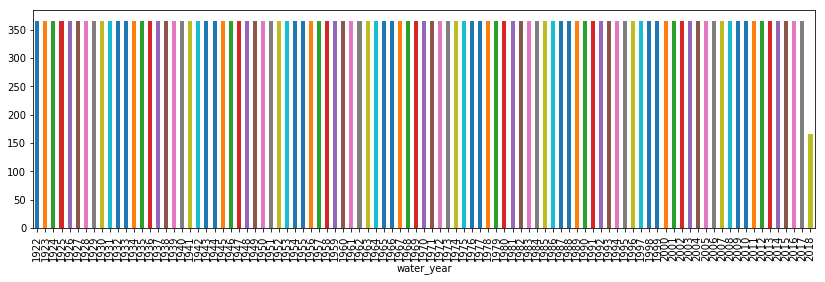

In [42]:
# Note this has a multiple index
plt.figure(figsize=(14,4))
wateryears['Lees Ferry']['Q','count'].plot(kind='bar')


## let's look at statistics to see if there are any missing days prior to 2018 (partial year)?

In [43]:
wateryears['Lees Ferry'].loc[wateryears['Lees Ferry'].index<2018].describe()

Q                                   Q_cfd                \
            count          mean           sum       count          mean   
count   96.000000     96.000000  9.600000e+01   96.000000  9.600000e+01   
mean   365.250000  14670.065508  5.358277e+06  365.250000  1.267494e+09   
std      0.435286   5026.789548  1.836241e+06    0.435286  4.343146e+08   
min    365.000000   3324.584699  1.216798e+06  365.000000  2.872441e+08   
25%    365.000000  11467.958904  4.185805e+06  365.000000  9.908316e+08   
50%    365.000000  12694.508197  4.639820e+06  365.000000  1.096806e+09   
75%    365.250000  18272.784920  6.683205e+06  365.250000  1.578769e+09   
max    366.000000  28237.978142  1.033510e+07  366.000000  2.439761e+09   

                           Q_af                              
                sum       count          mean           sum  
count  9.600000e+01   96.000000     96.000000  9.600000e+01  
mean   4.629551e+11  365.250000  29097.717394  1.062801e+07  
std    1.586512e+11    0.435286   9970.514555  3.642139e+06  
min    1.051313e+11  365.000000   6594.232724  2.413489e+06  
25%    3.616536e+11  365.000000  22746.416987  8.302442e+06  
50%    4.008804e+11  365.000000  25179.247615  9.202970e+06  
75%    5.774289e+11  365.250000  36243.623542  1.325597e+07  
max    8.929526e+11  366.000000  56009.341424  2.049942e+07

## Nice! 25% are leap years (mean is 365.25), and no years have less than 365 days

## The Colorado River Compact mandates there should be 7.5E6 Acre-feet /year
## of flow at Lee's Ferry. Is that happening?
https://en.wikipedia.org/wiki/Colorado_River_Compact 

https://www.usbr.gov/lc/region/pao/pdfiles/crcompct.pdf

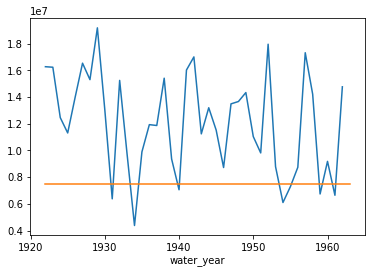

In [44]:
wateryears['Lees Ferry']['Q_af','sum'].loc[wateryears['Lees Ferry'].index<1963].plot()
plt.plot([1922,1963],[7.5e6,7.5e6])

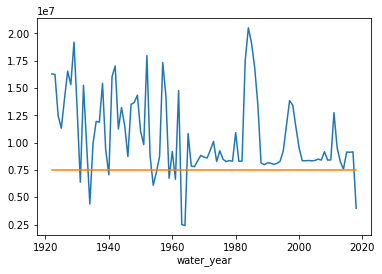

In [45]:
wateryears['Lees Ferry']['Q_af','sum'].loc[wateryears['Lees Ferry'].index].plot()
plt.plot([1922,wateryears['Lees Ferry'].index.max()],[7.5e6,7.5e6])

## Let's do some more exploration of the flow over all record

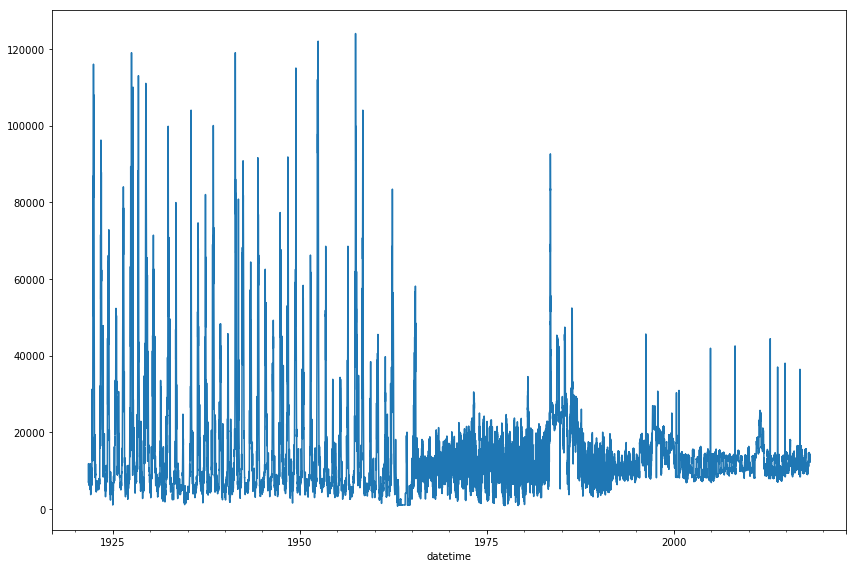

In [91]:
plt.figure(figsize=(12,8))
df_dict['Lees Ferry'].Q.plot()
plt.tight_layout()
plt.savefig('LeesFerryOnePlot.pdf')

## aggregate by group

In [47]:
nwis_df = df_dict['Lees Ferry'].copy()

### first we can apply functions to `groupby` grouping

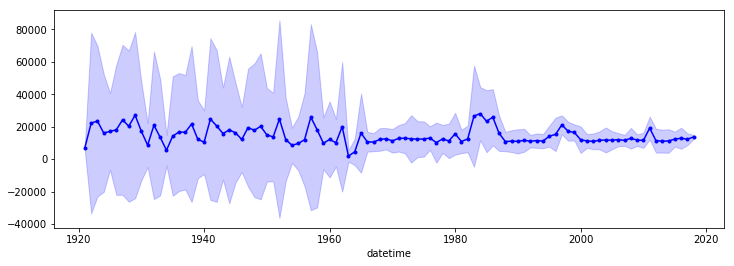

In [48]:
fig = plt.figure(figsize=(12,4))

mean_Q = nwis_df.Q.groupby(nwis_df.index.year).mean()
lower_CI = mean_Q - 2*nwis_df.Q.groupby(nwis_df.index.year).std()
upper_CI = mean_Q + 2*nwis_df.Q.groupby(nwis_df.index.year).std()
ax = mean_Q.plot(style='b.-')
plt.fill_between(lower_CI.index,lower_CI,upper_CI, color='b',alpha = 0.2)

# can accomplish this in one step using `aggregate`

In [49]:
Q_agg = nwis_df.Q.groupby(nwis_df.index.year).aggregate([np.min, np.mean, np.std])

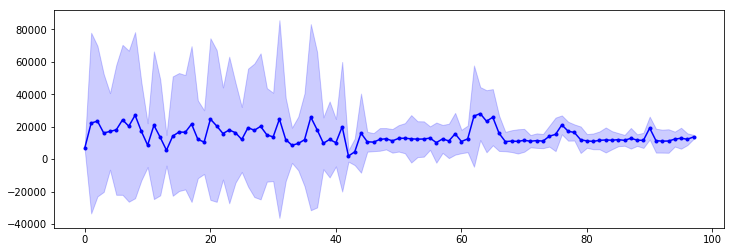

In [50]:
def plot_agg(Q_agg_in):
    Q_agg = Q_agg_in.copy()
    Q_agg.reset_index(drop=True, inplace=True)
    fig = plt.figure(figsize=(12,4))
    lower_CI = Q_agg['mean'] - 2*Q_agg['std']
    upper_CI = Q_agg['mean'] + 2*Q_agg['std']
    ax = Q_agg['mean'].plot(style='b.-')
    plt.fill_between(Q_agg.index,lower_CI,upper_CI, color='b',alpha = 0.2)
plot_agg(Q_agg)

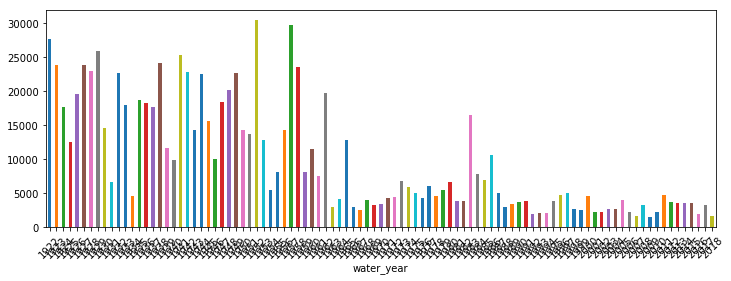

In [51]:
fig = plt.figure(figsize=(12,4))
nwis_df.Q.groupby(nwis_df.water_year).std().plot(kind='bar',rot=45)

### how hard to change from annual aggregation to monthly?

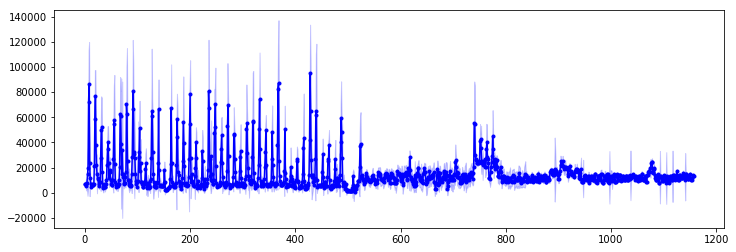

In [52]:
Q_agg_month = nwis_df.Q.groupby([nwis_df.index.year, nwis_df.index.month]).aggregate([np.min, np.mean, np.std])
plot_agg(Q_agg_month)

## navigate

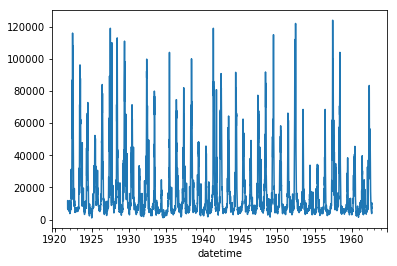

In [53]:
nwis_df.loc[nwis_df.water_year<1963].Q.plot()

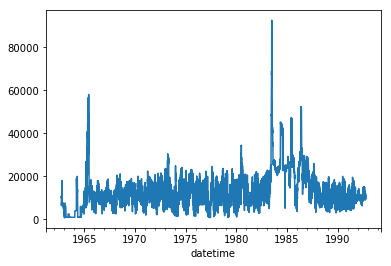

In [54]:
nwis_df.loc[(nwis_df.water_year<1993) & (nwis_df.water_year>=1963)].Q.plot()

## set values

In [55]:
nwis_df = df_dict['Lees Ferry'].copy()
nwis_df.loc[(nwis_df.index.year<1990) & (nwis_df.index.year>1948), 'Q'] *= 10

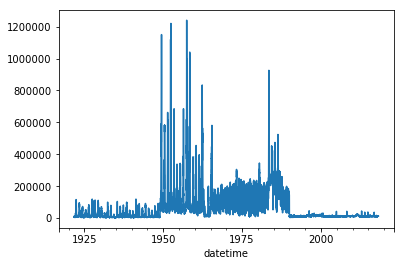

In [56]:
nwis_df.Q.plot()

In [57]:
# set them back
nwis_df.loc[(nwis_df.index.year<1990) & (nwis_df.index.year>1948), 'Q'] /= 10

## groupby

In [89]:
plot_fig=True
if plot_fig:
    with PdfPages(os.path.join('data','allyears_LeesFerry.pdf')) as outpdf:
        for cname,cgroup in nwis_df.groupby(nwis_df.index.year):
            print(cname)
            plt.figure()
            cgroup.Q.plot(title=cname)
            plt.ylabel('cfs')
            plt.xlabel('date')
            plt.tight_layout()
            outpdf.savefig()
            plt.close('all')


1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018


## now let's look at Lees Ferry and the Grand Canyon together

## we checked out the Lees Ferry record and found no gaps, but what about Grand Canyon?

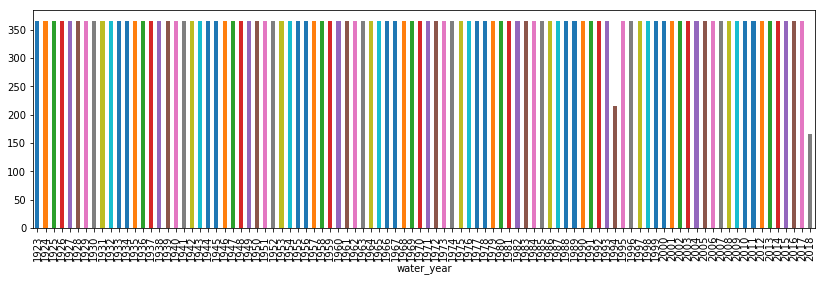

In [59]:
# Note this has a multiple inbdex
plt.figure(figsize=(14,4))
wateryears['Grand Canyon']['Q','count'].plot(kind='bar')


## crumbs... looks like some year in the 1990s is short some data

In [60]:
wateryears['Grand Canyon'].loc[wateryears['Grand Canyon'].index<2018].describe()

Q                                   Q_cfd                \
            count          mean           sum       count          mean   
count   95.000000     95.000000  9.500000e+01   95.000000  9.500000e+01   
mean   363.684211  15087.579270  5.493128e+06  363.684211  1.303567e+09   
std     15.319479   5002.900844  1.849252e+06   15.319479  4.322506e+08   
min    216.000000   3756.038251  1.374710e+06  216.000000  3.245217e+08   
25%    365.000000  12004.912456  4.387805e+06  365.000000  1.037224e+09   
50%    365.000000  13202.732240  4.832200e+06  365.000000  1.140716e+09   
75%    365.500000  18586.231492  6.793290e+06  365.500000  1.605850e+09   
max    366.000000  28593.442623  1.046520e+07  366.000000  2.470473e+09   

                           Q_af                              
                sum       count          mean           sum  
count  9.500000e+01   95.000000     95.000000  9.500000e+01  
mean   4.746062e+11  363.684211  29925.845765  1.089549e+07  
std    1.597754e+11   15.319479   9923.131892  3.667947e+06  
min    1.187749e+11  216.000000   7450.010329  2.726704e+06  
25%    3.791064e+11  365.000000  23811.451271  8.703104e+06  
50%    4.175021e+11  365.000000  26187.297619  9.584551e+06  
75%    5.869403e+11  365.500000  36865.337177  1.347433e+07  
max    9.041933e+11  366.000000  56714.396558  2.075747e+07

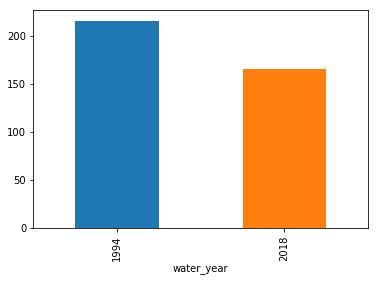

In [61]:
wateryears['Grand Canyon']['Q','count'].loc[wateryears['Grand Canyon']['Q','count']<300].plot(kind='bar')

## so what happens if we try to combine the datasets on a common time index?

## let's work just with 1993-1995, making specific dataframes for now

In [62]:
dfGC = df_dict['Grand Canyon'].copy()
dfLF = df_dict['Lees Ferry'].copy()



## is the GC data less complete?

In [63]:
print(len(dfGC))
print(len(dfLF))

34716
35230


## how does this sort out with `groupby` and `aggregate`?

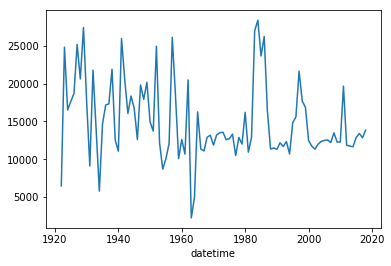

In [64]:
df_GC_agg = dfGC.groupby(dfGC.index.year).aggregate([np.mean,np.std,'count'])
df_GC_agg['Q','mean'].plot()

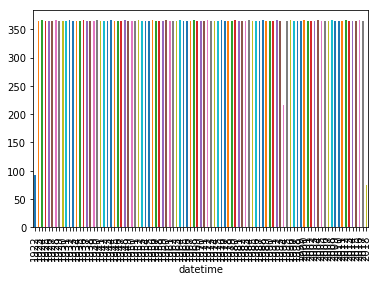

In [65]:
df_GC_agg['Q','count'].plot(kind='bar')

## let's trim down to the years around 1994 to explore how to merge them

In [66]:
dfGC = dfGC.loc[(dfGC.index.year>=1993) & (dfGC.index.year<=1995)]
dfLF = dfLF.loc[(dfLF.index.year>=1993) & (dfLF.index.year<=1995)]

## one easy way is `pd.concat` -- note difference between `inner` and `outer` join

In [67]:
df_combined=pd.concat([dfLF.Q,dfGC.Q],axis=1,join='inner')

df_combined.columns = [['Q_LF', 'Q_GC']]
df_combined.dtypes

Q_LF    int64
Q_GC    int64
dtype: object

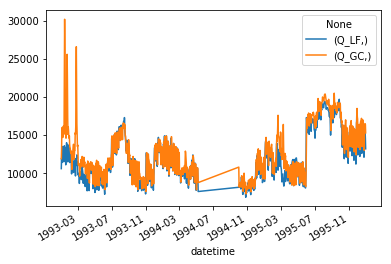

In [68]:
df_combined.plot()

In [69]:
df_combined=pd.concat([dfLF.Q,dfGC.Q],axis=1,join='outer')
df_combined.columns = [['Q_LF', 'Q_GC']]
df_combined.dtypes

Q_LF      int64
Q_GC    float64
dtype: object

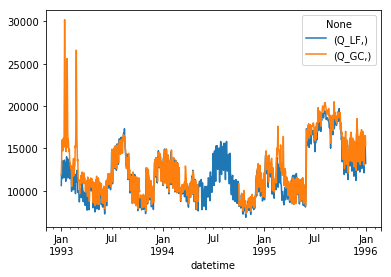

In [70]:
df_combined.plot()

## how can we fill in the missing data?

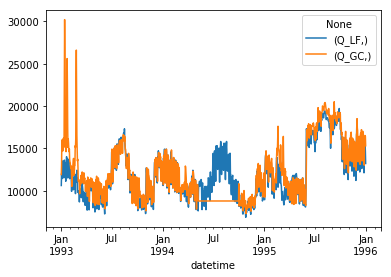

In [71]:
df_ffill=df_combined.fillna(method='ffill')
df_ffill.plot()

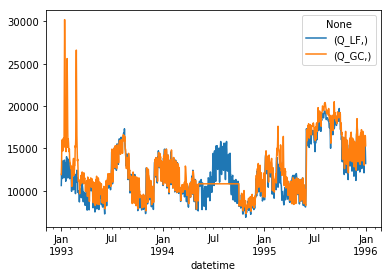

In [72]:
df_bfill=df_combined.fillna(method='bfill')
df_bfill.plot()

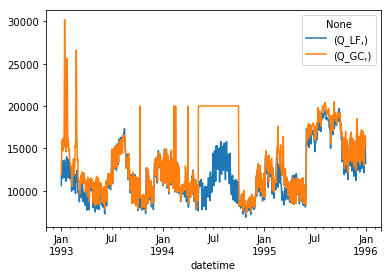

In [73]:
df_val = df_combined.fillna(value=20000)
df_val.plot()

## or we can impute from the other series somehow

## first just drop the NaN values for comparison

In [74]:
df_combined.to_csv('tmp')
df_combined = pd.read_csv('tmp', index_col=0)
df_dropna = df_combined.dropna()

In [75]:
len(df_dropna)

946

In [76]:
df_dropna.head()

,Q_LF,Q_GC
1993-01-01,10600.0,11900.0
1993-01-02,12000.0,13000.0
1993-01-03,11400.0,15700.0
1993-01-04,12900.0,16000.0
1993-01-05,12900.0,15600.0


In [77]:
df_dropna['Qrat'] = df_dropna.Q_GC/df_dropna.Q_LF


/Users/mnfienen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
df_dropna.head()

,Q_LF,Q_GC,Qrat
1993-01-01,10600.0,11900.0,1.122642
1993-01-02,12000.0,13000.0,1.083333
1993-01-03,11400.0,15700.0,1.377193
1993-01-04,12900.0,16000.0,1.240310
1993-01-05,12900.0,15600.0,1.209302


## ok, let's find the mean ratio and apply that to fill in missing data

In [79]:
mean_rat = df_dropna.Qrat.mean()
mean_rat

1.0645886932452682

In [80]:
df_combined['Q_LF'] = [float(i) for i in df_combined['Q_LF'].values]
df_combined.dtypes

Q_LF    float64
Q_GC    float64
dtype: object

In [81]:
df_combined.Q_GC=df_combined.Q_GC.fillna(df_combined.Q_LF*mean_rat)
        

In [82]:
np.unique(np.isnan(df_combined.Q_GC))

array([False,  True], dtype=bool)

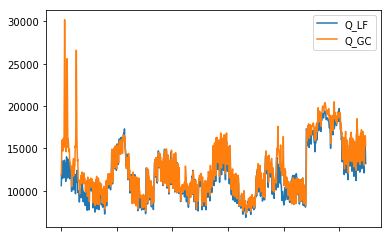

In [83]:
df_combined.plot()

In [84]:
dfGC_monthly = dfGC.resample('M')

In [85]:
dfGC_monthly

DatetimeIndexResampler [freq=<MonthEnd>, axis=0, closed=right, label=right, convention=start, base=0]

In [86]:
dfGC_monthly.mean()

,Q,water_year,Q_cfd,Q_af
datetime,,,,
1993-01-31,17458.064516,1993.0,1.508377e+09,34627.645477
1993-02-28,14407.142857,1993.0,1.244777e+09,28576.216724
1993-03-31,11346.129032,1993.0,9.803055e+08,22504.770406
1993-04-30,10671.333333,1993.0,9.220032e+08,21166.329583
1993-05-31,10136.451613,1993.0,8.757894e+08,20105.404727
1993-06-30,10604.333333,1993.0,9.162144e+08,21033.436716
1993-07-31,14522.580645,1993.0,1.254751e+09,28805.184763
1993-08-31,14961.290323,1993.0,1.292655e+09,29675.354715
1993-09-30,11186.333333,1993.0,9.664992e+08,22187.819531
